In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import segyio
import matplotlib.patches as patches
#from shapely.geometry import Polygon
import pandas as pd
import re
from scipy.interpolate import griddata

In [4]:
def read_seismic_cube(file_path):
    """
    :param file_path: Путь к файлу
    :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
    а также словарю сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
    """
    with segyio.open(file_path, 'r') as segyfile:
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        cube = segyio.tools.cube(segyfile)
        traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
        
    
    return x, y, z, traces

In [5]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
ilines, xlines, samples_0, traces = read_seismic_cube(file_path)
samples = list()
for i in range(len(samples_0)):
    samples.append(-int(samples_0[i]))

In [6]:
def extract_segy_data(file_path):
    with segyio.open(file_path, 'r') as segyfile:
        # Извлечение координат линий и образцов
        x = list(segyfile.ilines)
        y = list(segyfile.xlines)
        z = list(segyfile.samples)
        coord_x = set()
        coord_y = set()
        # Создание куба данных
        cube = segyio.tools.cube(segyfile)

        # Извлечение координат из заголовков
        traces = {}
        for i in range(len(x)):
            for j in range(len(y)): # Получение индекса записи
                index = i * len(y) + j

                # Получение данных записи
                trace_data = cube[i][j][:]

                # Извлечение заголовка записи
                trace_header = segyfile.header[index]

                # Получение координат X и Y из заголовка записи
                coord_x.add(trace_header[segyio.TraceField.SourceX])
                coord_y.add(trace_header[segyio.TraceField.SourceY])
                traces[ f"{trace_header[segyio.TraceField.SourceX]}_{trace_header[segyio.TraceField.SourceY]}"] = cube[i][j][:]
    return coord_x, coord_y, traces

In [8]:
file_path = 'C:/HV/Seismic/datas/Cube_TWT.segy'
coord_x, coord_y, traces_real = extract_segy_data(file_path)
x_min = min(coord_x)
y_min = min(coord_y)
delta_x = round(((max(coord_x)-min(coord_x))/ len(ilines)), 3)
delta_y = round(((max(coord_y)-min(coord_y))/ len(xlines)), 3)

In [9]:
def karta_gorizont(dict, name):
    # Извлечение данных для отрисовки
    points = []
    values = []
    for coord_str, value in dict.items():
        x, y = map(int, coord_str.split('_'))
        points.append((x, y))
        values.append(value)
        
# Создание графика
    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(x=list(zip(*points))[0], y=list(zip(*points))[1], c=values)
    plt.xticks([ilines[0], ilines[100], ilines[200], ilines[300], ilines[400], ilines[500], ilines[-1]])
    plt.yticks([xlines[0], xlines[100], xlines[200], xlines[300], xlines[400], xlines[500], xlines[-1]])
    plt.title(name)
    plt.xlabel('Инлайны')
    plt.ylabel('Кросслайны')
    #plt.colorbar(scatter, label=' ')
    plt.colorbar(scatter, ticks=[0, 1], label=' ')



    plt.grid(False)  # Отключение сетки
    plt.show()

In [10]:
def gorizont_coord(file):
    with open(file, 'r') as f:
        gorizon = {}
        for line in f:
            if not line.startswith('#'):  # Пропуск строк, начинающихся с #
                x, y, z, *rest = line.split()  # Разбиение строки по столбцам
                x = int(x.split('.')[0])  # Получение целочисленного значения из первого столбца
                y = int(y.split('.')[0])  # Получение целочисленного значения из второго столбца
                z = int(z.split('.')[0])  # Получение целочисленного значения из третьего столбца
                gorizon[ f"{x}_{y}"]  = z  # Добавление данных в словарь
        
        new_gorizont = {}
        for key in gorizon:
            x, y = int(key.split('_')[0]), int(key.split('_')[1])
            gorizon_x = int((x - x_min) // delta_x +1 + min(ilines))
            gorizon_y = int((y - y_min) // delta_y +1 + min(xlines))
            if (gorizon[key] % 2 ) == 0:
                index_samples = gorizon[key]
            else:
                index_samples = gorizon[key] +1
        
            if traces[f"{gorizon_x}_{gorizon_y}"][samples.index(index_samples)] >0:
                c = 1
            else:
                c = 0
            new_gorizont[f"{gorizon_x}_{gorizon_y}"] = c        
    return new_gorizont

In [11]:
def procent (dict):
    chet_pologit = 0
    for key in dict:
        if dict[key] == 1:
            chet_pologit += 1
    print(chet_pologit)
    print(round(chet_pologit / len(dict) * 100, 3))

25377
31.69


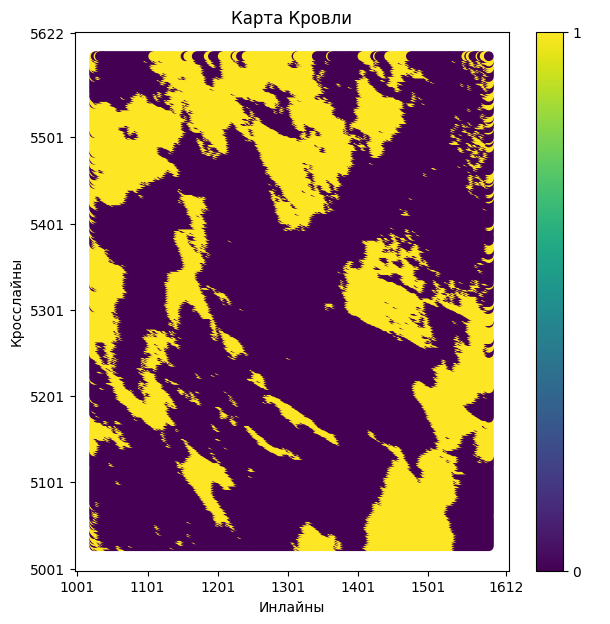

In [13]:
new_gorizont = gorizont_coord('C:/HV/Seismic/datas/TWT_Top_U1.txt')
procent(new_gorizont)
karta_gorizont(new_gorizont, 'Карта Кровли')

26384
32.947


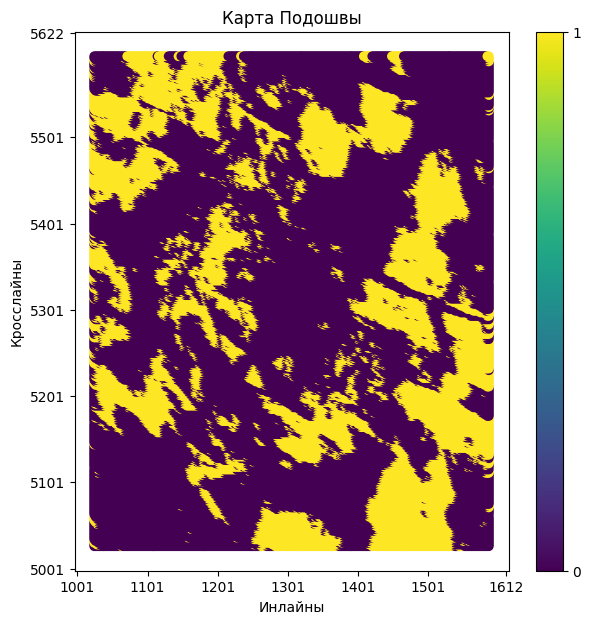

In [14]:
new_gorizont_1 = gorizont_coord('C:/HV/Seismic/datas/TWT_Bottom_U1.txt')
procent(new_gorizont_1)
karta_gorizont(new_gorizont_1, 'Карта Подошвы')